# Select Machine Learning Algorithms

Various machine learning algorithms exist that are useful to approximate linear and nonlinear functions. The best strategy to select a suitable algorithm is to identify a short list of techniques appropriate for a particular problem and evaluate their performance on how well they capture the underlying pattern.

For this specific problem, a linear regression and feed forward neural netowrk based models will be developed and compared. 

+ Linear regression provides greater flexibility in modeling exercise for linear problems and it is simple to interpret patterns. 
+ Artifial neural network is a power deep learning techniques to approximate .

Given the limited time allocated for this coding challenge, I will only fit a linear regression model to predict crew size. From earlier data exploration, the linear regression assumptions are met:

+ Visual plot of data shows a linear relationship between features and a target variable
+ Thie histogram and Q-Q plots showed all variables are nearly normally distributed
+ VIF test shows no or little multicollinearity

# Fit Linear Regression

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


pd.options.display.max_columns = 150
data = pd.read_csv('combined_2007&2012.csv')
features_data = pd.read_csv('features.csv')
targets_data = pd.read_csv('targets.csv')
feature_names = features_data.columns
target_names = targets_data.columns
feature_names

Index(['area_ha', 'lake_perim', 'elv', 'ph', 'turb', 'cl', 'cond', 'na', 'doc',
       'k', 'mg', 'ca', 'so4', 'sio2', 'chla', 'secmean', 'd18o_h2o', 'dd_h2o',
       'e_i', 'rt'],
      dtype='object')

In [40]:
target_names

Index(['tn', 'tp'], dtype='object')

In [53]:
data.select_dtypes(include=('object')).head(1)

,id,date,epa_reg,urban,lake_origin,site_id_x
0,NLA06608-0001,2007-07-31,Region_8,NO,NATURAL,NaN


In [42]:
cols = ['chla', 'secmean', 'turb', 'k', 'na', 'e_i', 'rt']
for col in cols:
    data[col] = pd.to_numeric(data[col], errors='coerce').dropna()

In [33]:
data = data.dropna()

In [55]:
data['turb'] = data['turb'].fillna(data['turb'].mean())
data['na'] = data['na'].fillna(data['na'].mean())
data['chla'] = data['chla'].fillna(data['chla'].mean())
data['secmean'] = data['secmean'].fillna(data['secmean'].mean())
data['e_i'] = data['e_i'].fillna(data['e_i'].mean())
data['rt'] = data['rt'].fillna(data['rt'].mean())
data['k'] = data['k'].fillna(data['rt'].mean())

In [54]:
data.isnull().sum()

Unnamed: 0        0
id             1220
date              0
lat               0
lon               0
epa_reg           0
urban             0
lake_origin       0
area_ha           0
lake_perim        0
elv               0
ph                0
tn                0
tp                0
turb              0
cl                0
cond              0
na                0
doc               0
k                 2
mg                0
ca                0
so4               0
sio2              0
chla              0
secmean           0
d18o_h2o          0
dd_h2o            0
e_i               0
rt                0
site_id_x      1241
dtype: int64

In [24]:
from scipy import stats

cols = ['chla', 'secmean']
for col in cols:
    data.loc[:, col] = data.loc[:, col].fillna(stats.mode)
    
data.isnull().sum()

Unnamed: 0        0
id             1220
date              0
lat               0
lon               0
epa_reg           0
urban             0
lake_origin       0
area_ha           0
lake_perim        0
elv               0
ph                0
tn                0
tp                0
turb             40
cl                0
cond              0
na                1
doc               0
k                 2
mg                0
ca                0
so4               0
sio2              0
chla              0
secmean           0
d18o_h2o          0
dd_h2o            0
e_i               4
rt               57
site_id_x      1241
dtype: int64

### Select Error Metrics

Mean Squared Error (MSE), R-squared, Adjusted R-squared and mean of the R-squared values obtained by the k-Fold Cross Validation. 

In [25]:
error_metrics = pd.DataFrame({'Model': [],
                           'Number of Features': [],
                           'Root Mean Squared Error (testing)':[],
                           'R-squared (testing)':[],
                           'Adjusted R-squared (testing)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           '5-Fold Cross Validation':[]})

In [26]:

error_metrics.drop(error_metrics.index[0:104])

,Model,Number of Features,Root Mean Squared Error (testing),R-squared (testing),Adjusted R-squared (testing),R-squared (training),Adjusted R-squared (training),5-Fold Cross Validation


### Rank of features on correlation score to target variables

In [27]:
# Rank of feature based on cost-effectiveness and simplicity of testing procedures
feature_rank = {1:'ph', 2:'turb', 3:'cond', 4:'secmean', 5: 'doc', 6:'k', 7:'mg', 
                8:'so4', 9:'cl', 10: 'chla', 11: 'sio2', 11:'d18o_h2o', 13: 'dd_h2o', 14: 'e_i', 15: 'rt'}

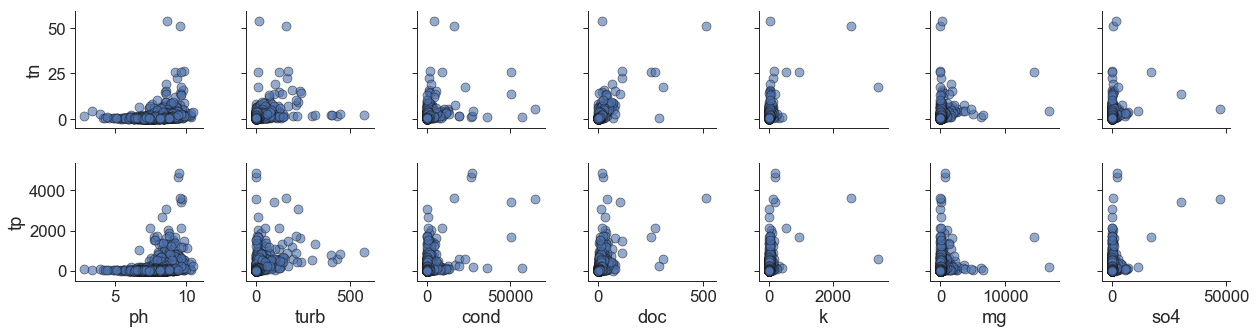

In [28]:
# display top 7 features
sns.set(style="ticks", color_codes=True)
#fig, ax = plt.subplots(figsize=(15,6))
sns.set_context("paper", font_scale=1.9)
sns.pairplot( data=data, y_vars=['tn', 'tp'], x_vars=['ph', 'turb', 'cond', 'doc', 'k', 'mg', 'so4'],size = 2.5, plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, diag_kind='kde')

## Simple Linear Regression

In this step, tn and tp are predicted using a single feature that was ranked as the most suitable based on cost-effectiveness and simplicity of field/laboratory testing criteria.

In [10]:
# fit simple linear regression model

def simple_linear_regression(features, target, feature_name, taret_name):
    # split data into train and test
    train_data, test_data = train_test_split(data, train_size = 0.75, random_state = 2)
    
    # fit linear regression
    lr = LinearRegression()
    x_train = np.array(train_data[feature], dtype = pd.Series).reshape(-1,1)
    y_train = np.array(train_data[target], dtype = pd.Series)
    lr.fit(x_train,y_train)
    
    # reshape test data
    x_test = np.array(test_data[feature], dtype = pd.Series).reshape(-1,1)
    y_test = np.array(test_data[target], dtype = pd.Series)

    # Validate and compute errors
    pred = lr.predict(x_test)
    rmse_test = float(format(np.sqrt(mean_squared_error(y_test, pred)),'.2f'))
    r2_train = float(format(lr.score(x_train, y_train),'.2f'))
    r2_test = float(format(lr.score(x_test, y_test),'.2f'))
    cv = float(format(cross_val_score(lr, data[[feature]], data[target],cv = 5).mean(),'.2f'))

    # Add error metrics in the error_metrcs dataframe
    row = error_metrics.shape[0]
    error_metrics.loc[row] = ['Simple Linear Regression','1 feature',  rmse_test, r2_test, '-', r2_train, '-', cv]
    plt.figure(figsize=(12,8))
      
    # print model attributes  
    
    print(lr.intercept_)
    print(lr.coef_)

In [11]:
# predict total nitrogen (tn)
feature = 'ph'
target = ['tn', 'tp']
feature_name = 'pH'
target_name = 'Total Nitrogen'

simple_linear_regression(feature, target, feature_name, target_name)

[  -5.9762162  -729.56726334]
[[  0.88910385]
 [105.17763106]]


<Figure size 864x576 with 0 Axes>

In [12]:
error_metrics

,Model,Number of Features,Root Mean Squared Error (testing),R-squared (testing),Adjusted R-squared (testing),R-squared (training),Adjusted R-squared (training),5-Fold Cross Validation
0,Simple Linear Regression,1 feature,155.69,0.04,-,0.08,-,0.05


In [13]:
# predict total phosphorus (tp)
feature = 'ph'
target = 'tp'
feature_name = 'pH'
target_name = 'Total Phosphorus'

simple_linear_regression(feature, target, feature_name, target_name)

-729.5672633422773
[105.17763106]


<Figure size 864x576 with 0 Axes>

Using ph feature result a poor fit. In order to improve this model, we need to more more features, it is defined as multiple regression.

### Multiple Linear Regression Model

#### Optimize Prediction Using Wrapper Method 
Using ranked features based on cost-effectiveness and simplicity of testing procedures, a subset of features will be used to train the multiple regression model. We use a forward selection iterative method in which we start with having two feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

In [14]:
# function to calculate adjusted R-Squared 
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

# function to fit multiple linear regression model 
def multiple_linear_Regression(features, target, feature_num):
    # split data into train and test
    train_data, test_data = train_test_split(data,train_size = 0.75, random_state = 2)

    # Fit model
    mlr = LinearRegression()
    mlr.fit(train_data[features],train_data[target])

    pred = mlr.predict(test_data[features])
    rmse_test = float(format(np.sqrt(mean_squared_error(test_data[target], pred)),'.2f'))
    r2_train = float(format(mlr.score(train_data[features],train_data[target]),'.2f'))
    adj_r2_train = float(format(adjustedR2(mlr.score(train_data[features],train_data[target]),
                                     train_data.shape[0],len(features)),'.2f'))
    r2_test = float(format(mlr.score(test_data[features],test_data[target]),'.2f'))
    adj_r2_test = float(format(adjustedR2(mlr.score(test_data[features],test_data[target]),
                                     test_data.shape[0],len(features)),'.2f'))
    cv = float(format(cross_val_score(mlr,data[features], data[target], cv = 5).mean(),'.3f'))

    row = error_metrics.shape[0]
    error_metrics.loc[row] = ['Multiple Linear Regression', feature_num, rmse_test, r2_test, adj_r2_test, r2_train, 
                              adj_r2_train, cv]   

#### Fit and Predict Total Nitrogen (tn)

In [56]:
# Feature in thier respective rank on cost-effectiveness and simplicity of testing procedures
feature_rank = ['ph','turb', 'cond', 'doc', 'k', 'mg', 'so4', 'cl', 'sio2', 'd18o_h2o', 
                'dd_h2o', 'e_i', 'rt']
for i in range(1, len(feature_rank)+1):
    feature = feature_rank[0:i+1]
    target = ['tn', 'tn']
    feature_num = str(i) + ' features'
    multiple_linear_Regression(feature, target, feature_num)

#### Fit and Predict Total Phosphorus (tn)

#### Select Best Features

In [57]:
error_metrics.sort_values(by = ['5-Fold Cross Validation', 'Root Mean Squared Error (testing)'], 
                          ascending = [False, True])

,Model,Number of Features,Root Mean Squared Error (testing),R-squared (testing),Adjusted R-squared (testing),R-squared (training),Adjusted R-squared (training),5-Fold Cross Validation
2,Multiple Linear Regression,3 features,1.46,0.11,0.10,0.60,0.60,0.538
5,Multiple Linear Regression,3 features,1.46,0.11,0.10,0.60,0.60,0.538
6,Multiple Linear Regression,4 features,1.67,-0.17,-0.17,0.62,0.62,0.515
7,Multiple Linear Regression,5 features,1.68,-0.18,-0.19,0.62,0.62,0.510
8,Multiple Linear Regression,6 features,1.68,-0.18,-0.20,0.62,0.62,0.482
9,Multiple Linear Regression,7 features,1.69,-0.20,-0.21,0.62,0.62,0.476
10,Multiple Linear Regression,8 features,1.68,-0.18,-0.20,0.62,0.62,0.403
11,Multiple Linear Regression,9 features,1.67,-0.18,-0.19,0.62,0.62,0.400
13,Multiple Linear Regression,11 features,1.67,-0.18,-0.20,0.63,0.62,0.389
12,Multiple Linear Regression,10 features,1.68,-0.19,-0.21,0.62,0.62,0.387


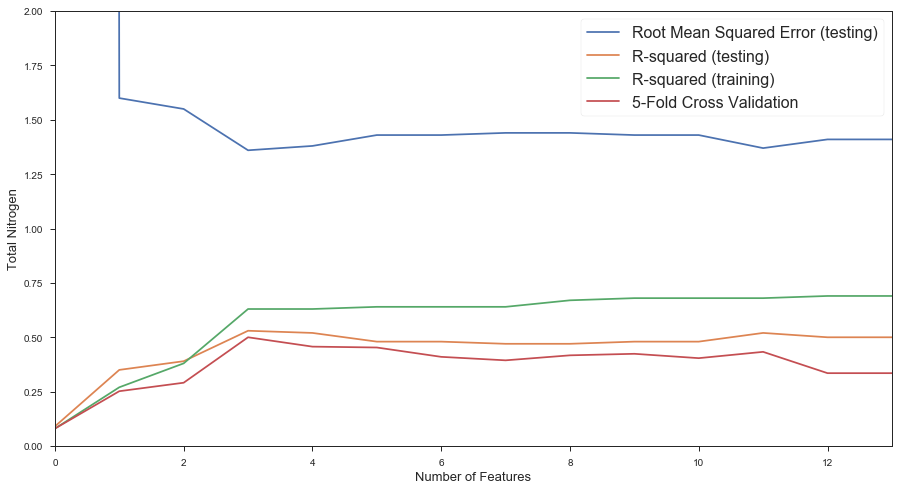

In [41]:
%matplotlib inline
plt.style.use('seaborn-notebook')
error_metrics.plot(figsize = (15,8))
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('Total Nitrogen', fontsize = 13)
plt.ylim(0,2)
plt.legend(fontsize=16)


Overall, the regression models fit best when the first three most ranked features, pH, cond, and turbidity, used. The fitted model needs to be checked if it is overfitting and undefitting.

### Regularization

Previously, features were manually adjusted to obtimum performance. This will apply regularization, where selected features are kept and the model adjusts coefficients. Regularization, significantly reduces the variance of the model, without substantial increase in its bias. Two regulization methods applied, Ridge and Lasso Regressions.

#### Ridge Regression

This will adding a penalty with α value. When we increase α, regularization increases. 

In [54]:
def multiple_linear_Regression_reg(α, features, target):
    # split data into train and test
    train_data, test_data = train_test_split(data,train_size = 0.75, random_state = 2)
    
    # Fit model
    mlr = linear_model.Ridge(alpha = α)
    mlr.fit(train_data[features],train_data[target])

    pred = mlr.predict(test_data[features])
    cv = float(format(cross_val_score(mlr,data[features], data[target], cv = 5).mean(),'.2f'))
    return cv

In [55]:
features =  ['ph','turb', 'cond']
target = ['tn', 'tp']
cv_ridge = []
for i in range(1, 70):
    c = multiple_linear_Regression_reg(i, features, target)
    cv_ridge.append (c)

Text(0.5, 0, 'Model penalizer (alpha)')

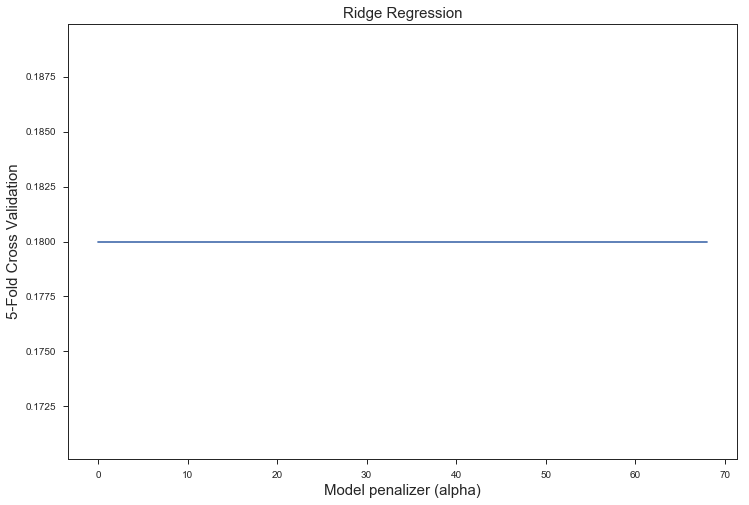

In [56]:
%matplotlib inline
plt.style.use('seaborn-notebook')
fig = plt.figure(figsize = (12, 8))
plt.plot(cv_ridge)
plt.title ('Ridge Regression', fontsize = 15)
plt.ylabel('5-Fold Cross Validation', fontsize = 15)
plt.xlabel('Model penalizer (alpha)', fontsize = 15)

It seems the penalizer didn't make a change in the model paramaters. This is a good indicator that the model is not overfitting. 

#### Lasso Regression

Lasso is works the same way but it shrinks coefficients to zero and can remove features. When α increases, lasso regression penalizes more.

In [59]:
def multiple_linear_Regression_Lasso(α, feature, target):
    # split data into train and test
    train_data, test_data = train_test_split(data,train_size = 0.75, random_state = 2)
    
    # Fit model
    mlr = linear_model.Lasso(alpha=α)
    mlr.fit(train_data[feature],train_data[target])

    pred = mlr.predict(test_data[feature])
    cv = float(format(cross_val_score(mlr,data[feature], data[target], cv = 5).mean(),'.2f'))
    return cv

Text(0.5, 0, 'Model penalizer (alpha)')

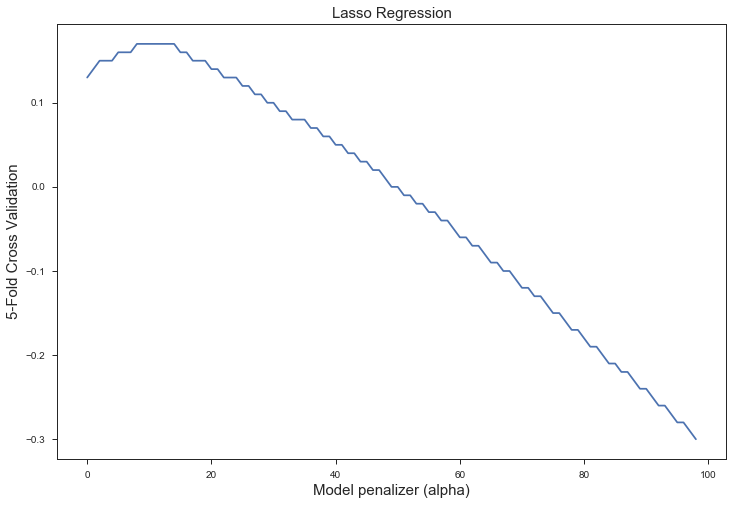

In [65]:
features =  ['ph','turb', 'cond']
target = ['tn', 'tp']
cvv_lasso = []
for i in range(1, 100):
    c = multiple_linear_Regression_Lasso(i, feature, target)
    cvv_lasso.append (c)
fig = plt.figure(figsize = (12, 8))
plt.plot(cvv_lasso)
plt.title ('Lasso Regression', fontsize = 15)
plt.ylabel('5-Fold Cross Validation', fontsize = 15)
plt.xlabel('Model penalizer (alpha)', fontsize = 15)

The lasso regression penalizer seems underfitting the model. As the α values increases, it will affect model in undersirable way. From these, rigdge is a good choice for this problem.

A linear regression fits modest on this data sets. In the next Jupyter nootebook, a neural network will be implemented